In [1]:
import fsps
import numpy as np 
import astropy.units as u
from astropy import units as U 
from astropy.cosmology import Planck13
# -- fomospec
from fomospec import util as UT
# -- plotting --
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [2]:
# read in lookback time bins (binning for SFH)
t_lookback = np.loadtxt('sfh_t_int.txt')
print(t_lookback)

[13.62782978 13.35107792 13.07432606 12.7975742  12.52082234 12.24407048
 11.96731862 11.69056676 11.4138149  11.13706304 10.86031118 10.58355932
 10.30680746 10.03005561  9.75330375  9.47655189  9.19980003  8.92304817
  8.64629631  8.36954445  8.09279259  7.81604073  7.53928887  7.26253701
  6.98578515  6.70903329  6.43228143  6.15552958  5.87877772  5.60202586
  5.325274    5.04852214  4.77177028  4.49501842  4.21826656  3.9415147
  3.66476284  3.38801098  3.11125912  2.83450726  2.55775541  2.28100355
  2.00425169  1.72749983  1.45074797  1.17399611  0.89724425  0.62049239
  0.34374053  0.06698867]


In [3]:
# read in SFH and ZH bases
nmf_sfh_basis = np.loadtxt('NMF_2basis_SFH_components_nowgt_lin_Nc4.txt')
nmf_zh_basis = np.loadtxt('NMF_2basis_Z_components_nowgt_lin_Nc2.txt')
Nbins = nmf_sfh_basis.shape[1]
Ncomp_sfh = nmf_sfh_basis.shape[0]
Ncomp_zh = nmf_zh_basis.shape[0]
print("%i bins" % Nbins)
print("SFH basis has %i components" % Ncomp_sfh)
print("ZH basis has %i components" % Ncomp_zh)

50 bins
SFH basis has 4 components
ZH basis has 2 components


In [4]:
# initalize fsps object
ssp = fsps.StellarPopulation(
    zcontinuous=1, # SSPs are interpolated to the value of logzsol before the spectra and magnitudes are computed
    sfh=0, # single SSP
    imf_type=1, # chabrier
    dust_type=2 # Calzetti (2000) 
    )

In [5]:
print('%s isochrone library' % ssp.isoc_library)
print('%s spectral library' % ssp.spec_library) 

pdva isochrone library
miles spectral library


In [6]:
def sspLum(theta): 
    ''' FSPS wrapper that deals with NMF SFH and ZH basis and other parameters. 
    
    :param theta: 
        numpy array that specifies parameters. 
        Indices 0 to Ncomp_sfh-1 specifies the SFH basis parameters. 
        Indices Ncomp_sfh to Ncomp_sfh + Ncomp_zh specifies the ZH basis parameters.
        Index -1 specifes tau_ISM (dust) 
        
    :return wave_rest
        rest-frame wavelength grid provided by FSPS
        
    :return lum_ssp:
        luminosity in uints of Lsun/AA of ssp. This can be converted to observed flux 
        of units erg/s/cm^2/Angstrom by multiplying x Lsun/(4pi dlum^2)/(1+z)
    '''
    theta_sfh = theta[:Ncomp_sfh]
    theta_zh = theta[Ncomp_sfh:Ncomp_sfh+Ncomp_zh]
    theta_dust = theta[-1] # dust parameter
    sfh = np.dot(theta_sfh, nmf_sfh_basis)
    zh = np.dot(theta_zh, nmf_zh_basis)
 
    for i, t, m, z in zip(range(len(t_lookback)), t_lookback, sfh, zh): 
        if m <= 0: # no star formation in this bin 
            continue
        ssp.params['logzsol'] = np.log10(z/0.0190) # log(Z/Zsun)
        ssp.params['dust2'] = theta_dust 
        wave_rest, lum_i = ssp.get_spectrum(tage=t, peraa=True) # in units of Lsun/AA
        if i == 0: lum_ssp = np.zeros(len(wave_rest))
        lum_ssp += m * lum_i 
    return wave_rest, lum_ssp

In [7]:
zh_maxprior = 0.04 
zh_max = zh_maxprior/np.max(nmf_zh_basis)

In [8]:
prior_min = np.zeros(9) 
prior_max = np.array([50., 50., 50., 50., zh_max, zh_max, zh_max, zh_max, 1e-4])

print('prior lower bounds: ', prior_min)
print('prior upper bounds: ', prior_max)

('prior lower bounds: ', array([0., 0., 0., 0., 0., 0., 0., 0., 0.]))
('prior upper bounds: ', array([5.0000000e+01, 5.0000000e+01, 5.0000000e+01, 5.0000000e+01,
       7.3282264e-03, 7.3282264e-03, 7.3282264e-03, 7.3282264e-03,
       1.0000000e-04]))


In [9]:
# test out how the spectra would look for a M* = 10^9.73 at z=0.1
zred = 0.1
d_lum = Planck13.luminosity_distance(zred).to(U.cm).value # luminosity distance in cm
factor_flux = UT.Lsun() / (4. * np.pi * d_lum**2) / (1. + zred) # luminosity to flux
Mstar = 10**9.73

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


Text(0,0.5,'metallicity, $Z$')

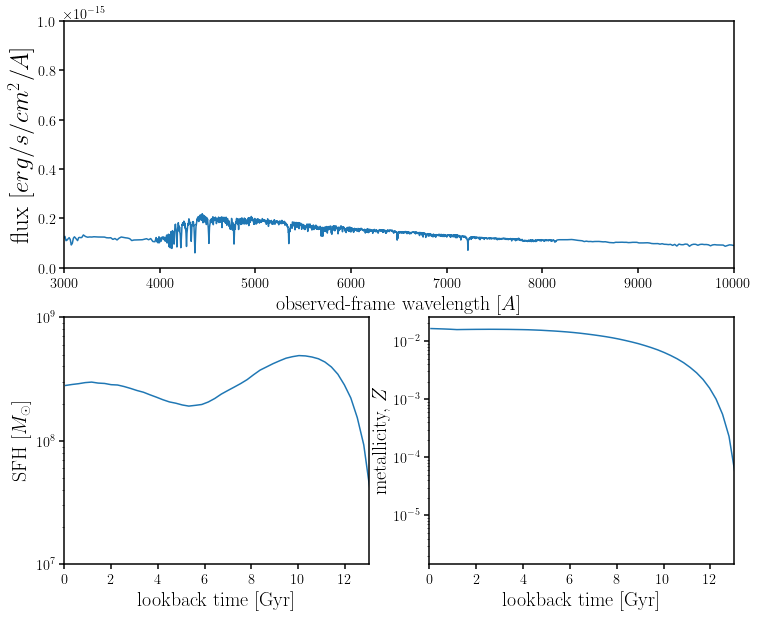

In [10]:
fig = plt.figure(figsize=(12, 10))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)
# plot spectra
sub = plt.subplot(gs[0,:])
tt_i = (prior_max - prior_min) * np.random.uniform(size=len(prior_min))
tt_i[:6] = np.array([1.4, 2.5, 3., 3., 0.003, 0.003])
w, lum_i = sspLum(tt_i)
wobs = w * (1. + zred)
norm = Mstar / np.sum(lum_i)
flux = lum_i * norm * factor_flux
sub.plot(wobs, flux, c='C0')
sub.set_xlabel('observed-frame wavelength [$A$]', fontsize=20)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('flux [$erg/s/cm^2/A$]', fontsize=25)
sub.set_ylim(0, 1e-15)
# plot SFH
sub = plt.subplot(gs[1,0]) # SFH
sfh = np.dot(tt_i[:Ncomp_sfh], nmf_sfh_basis)
sub.plot(t_lookback, sfh * norm)
sub.set_xlabel('lookback time [Gyr]', fontsize=20)
sub.set_xlim(0, 13)
sub.set_ylabel(r'SFH [$M_\odot$]', fontsize=20)
sub.set_yscale('log')
sub.set_ylim(1e7, 1e9)
# plot SFH
sub = plt.subplot(gs[1,1]) # SFH
zh = np.dot(tt_i[Ncomp_sfh:Ncomp_sfh+Ncomp_zh], nmf_zh_basis)
sub.plot(t_lookback, zh)
sub.set_xlabel('lookback time [Gyr]', fontsize=20)
sub.set_xlim(0, 13)
sub.set_yscale('log')
sub.set_ylabel("metallicity, $Z$", fontsize=20)